# Hilbert-Huang Transform (HHT) の例

このセクションでは、`gwexpy` ライブラリの `TimeSeries.hht()` を使って、模擬的な重力波信号に Hilbert-Huang 変換 (HHT) を適用する方法を示します。以下のコードでは、合成信号の生成から HHT 解析、そして結果の可視化までを順を追って説明します。

### Hilbert-Huang 変換 (HHT) とは

Hilbert-Huang 変換 (HHT) は、非定常かつ非線形な信号を解析するための手法であり、主に以下の 2 段階のプロセスで構成されます：

1. **経験的モード分解 (Empirical Mode Decomposition, EMD)**:
   複号な信号 $x(t)$ を、**固有モード関数 (Intrinsic Mode Function, IMF)** と呼ばれる、ほぼ単一の振動成分を持つ一連の関数の和に分解します。
   $$x(t) = \sum_{i=1}^n c_i(t) + r_n(t)$$
   ここで $c_i(t)$ は $i$ 番目の IMF、$r_n(t)$ は分解後の残差です。IMF は以下の 2 つの条件を満たす必要があります：
   - 全データ領域で、極値（極大・極小）の数とゼロ交差の数が等しいか、最大 1 だけ異なる。
   - 局所的な極大値の包絡線と局所的な極小値の包絡線の平均値が、どの点においてもゼロ（またはほぼゼロ）である。

2. **ヒルベルトスペクトル解析 (Hilbert Spectral Analysis, HSA)**:
   各 IMF に対してヒルベルト変換を適用し、**瞬時振幅 (Instantaneous Amplitude)** と **瞬時周波数 (Instantaneous Frequency)** を算出します。
   各 IMF $c(t)$ から、ヒルベルト変換 $\hat{c}(t)$ を用いて解析信号 (Analytic Signal) $z(t)$ を構築します：
   $$z(t) = c(t) + i\hat{c}(t) = a(t) e^{i \theta(t)}$$
   ここで、瞬時振幅 $a(t)$ と瞬時位相 $\theta(t)$ は以下のように定義されます：
   $$a(t) = \sqrt{c(t)^2 + \hat{c}(t)^2}$$
   $$\theta(t) = \arctan\left(\frac{\hat{c}(t)}{c(t)}\right)$$
   さらに、瞬時周波数 $f(t)$ は周期的な変化率として求められます：
   $$f(t) = \frac{1}{2\pi} \frac{d\theta(t)}{dt}$$

これらのプロセスにより、従来のフーリエ変換やウェーブレット変換では捉えきれない、時間とともに変化する局所的な周波数特性を高い時間解像度で視覚化することが可能になります。

## 1. 合成重力波信号の生成

まず、CCSN（核心崩壊超新星）やCBC（連星合体）からの重力波を模倣した合成信号を作成します。この信号には次の特徴を含めます：

- **低周波正弦波成分**（例：18.4 Hz）を含み、途中で急に停止させることで急峻なトランジションを表現する。
- **チャープ成分**：周波数が時間とともに線形に増加する正弦波（チャープ信号）を重ね合わせ、周波数変調を再現する。さらにこのチャープ成分の振幅を時間とともに増加させ、振幅変調も導入する。

TimeSeries([ 0.        ,  0.0576767 ,  0.1145838 , ...,
            -0.30943082, -0.94934894, -0.80811593]
           unit: strain,
           t0: 0.0 s,
           dt: 0.001 s,
           name: SyntheticGW,
           channel: None)


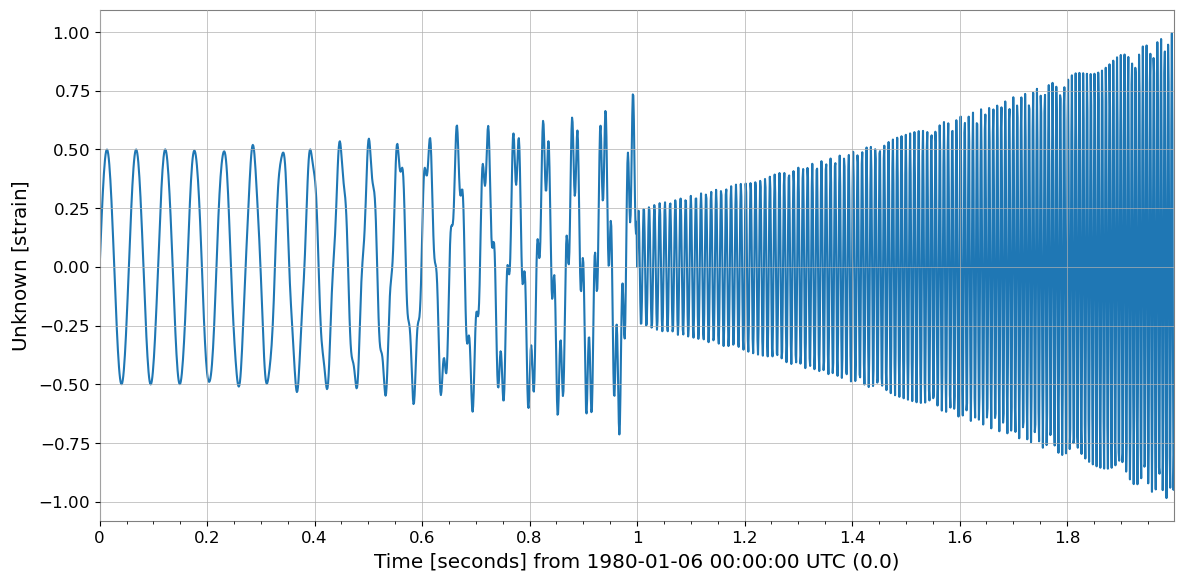

In [1]:
import numpy as np
from gwexpy.timeseries import TimeSeries
import matplotlib.pyplot as plt

# 時間軸の設定
T = 2.0        # 信号長さ [秒]
dt = 0.001     # サンプリング間隔 [秒] (サンプリングレートは 1000 Hz)
t = np.arange(0, T, dt)

# 低周波成分: 18.4 Hz の正弦波 (0～1秒で存在し、その後は0となる)
f_low = 18.4  # 低周波 [Hz]
low_wave = np.sin(2 * np.pi * f_low * t) *0.5
# 1秒以降をゼロにして急停止を表現
low_wave[t >= 1.0] = 0.0

# チャープ成分: 50 Hz から 150 Hz へ線形に周波数が上昇する正弦波 (0～2秒)
f0, f1 = 50, 150  # チャープ開始/終了周波数 [Hz]
# チャープの位相：φ(t) = 2π * [f0 * t + (f1 - f0) / (2T) * t^2]
phase = 2 * np.pi * (f0 * t + 0.5 * (f1 - f0) / T * t**2)
chirp_wave = np.sin(phase)
# チャープ振幅を時間とともに増加させる（振幅変調: 二次関数で0から1へ）
amplitude_env = (t / T)**2
chirp_wave *= amplitude_env

# 合成信号：低周波成分 + チャープ成分
signal = low_wave + chirp_wave

# gwexpy TimeSeries オブジェクトを作成（単位は重力波ひずみを想定して無次元に設定）
ts = TimeSeries(signal, t0=0, dt=dt, unit="strain", name="SyntheticGW")
print(ts)
ts.plot()
plt.show()

上記では、時間配列 `t` に対し、低周波18.4 Hzの波 (`low_wave`) と 50→150 Hzのチャープ波 (`chirp_wave`) を生成し、それらを加算しています。`low_wave` は 1.0 秒で強制的にゼロにし、信号の急停止を導入しています。また `chirp_wave` は振幅包絡 `amplitude_env` を掛けることで時間とともに振幅が増大するよう調整しています。最後に、データとサンプリング情報から `gwexpy` の `TimeSeries` オブジェクト `ts` を作成しています。


## 2. Hilbert-Huang 変換の実行

次に、`TimeSeries.hht()` メソッドを用いて HHT（EMD + Hilbert スペクトル解析）を実行します。`hht(output='dict')` とすると、EMDによる経験的モード分解 (EMD)を行い、その各成分に Hilbert 変換を適用して瞬時振幅と瞬時周波数を求めます。結果は以下の辞書で返されます：

- `result["imfs"]`: IMF（固有モード関数）毎の時系列（TimeSeriesDict形式）
- `result["ia"]`: IMF毎の瞬時振幅（TimeSeriesDict）
- `result["if"]`: IMF毎の瞬時周波数（TimeSeriesDict）
- `result["residual"]`: EMDで分解後に残った残余成分（あれば）

In [2]:
# HHTの実行（EMD法でIMF分解し、各IMFのHilbert解析を実施）
result = ts.hht(emd_method="emd", output="dict")

# EMD分解されたIMF群および瞬時特性を取得
imfs = result["imfs"]       # IMFのTimeSeriesDict（キーは "IMF1", "IMF2", ...）
ia_dict = result["ia"]      # IMF毎の瞬時振幅（Instantaneous Amplitude）
if_dict = result["if"]      # IMF毎の瞬時周波数（Instantaneous Frequency）
residual = result.get("residual")  # 残留成分（存在しない場合は None）

# 分解されたIMFの一覧を表示
print("IMFs:", list(imfs.keys()))
if residual is not None:
    print("Residual is present.")

IMFs: ['IMF1', 'IMF2', 'IMF3', 'IMF4', 'IMF5', 'IMF6', 'IMF7', 'IMF8']
Residual is present.


上記コードにより、合成信号が EMD によっていくつかの IMF に分解され、それぞれについて瞬時振幅 (`ia_dict`) と瞬時周波数 (`if_dict`) が計算されます。`emd_method="emd"` を指定しているため基本的な EMD を使用しています（必要に応じて `"eemd"` なども指定可能です）。

## 3. IMFごとの波形を描画

HHTの結果得られた各IMFの時間波形をプロットします。IMFは高周波成分から順に IMF1, IMF2, ... と命名されています。ここでは各IMFを個別のサブプロットに表示し、時間領域での振る舞いを確認します（縦軸は振幅、横軸は時間）。

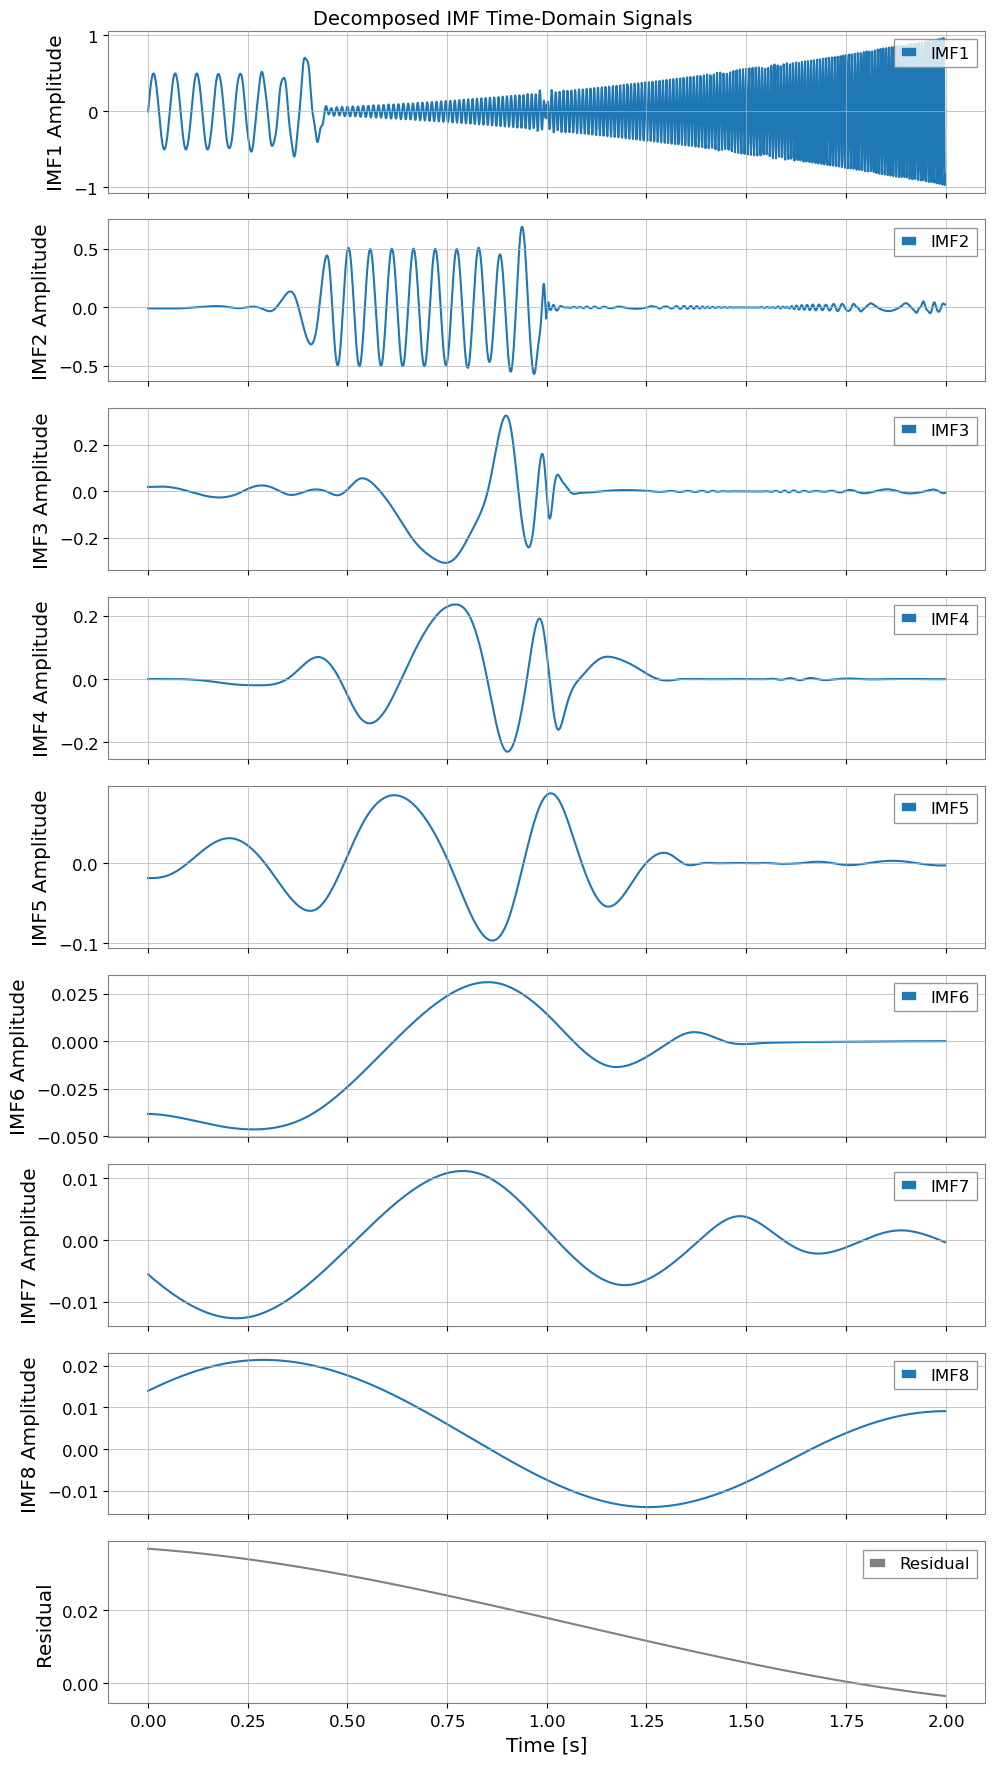

In [3]:
# IMFごとの波形をプロット
num_imfs = len(imfs)
num_plots = num_imfs + (1 if residual is not None else 0)
fig1, axes = plt.subplots(num_plots, 1, figsize=(10, 2 * num_plots), sharex=True)
fig1.suptitle("Decomposed IMF Time-Domain Signals", fontsize=14)
if num_plots == 1:
    axes = [axes]

for i, (key, imf_ts) in enumerate(imfs.items()):
    axes[i].plot(imf_ts, label=key)
    axes[i].set_ylabel(f"{key} Amplitude")
    axes[i].legend(loc="upper right")

# 残差がある場合、最後に追加表示
if residual is not None:
    axes[-1].plot(residual, color='gray', label="Residual")
    axes[-1].set_ylabel("Residual")
    axes[-1].legend(loc="upper right")

axes[-1].set_xlabel("Time [s]")
plt.tight_layout()
plt.show()

上記では、`plt.subplots` を用いて IMF の数だけ（および必要に応じて残留成分の分も）縦にサブプロットを作成し、それぞれに対応する波形を描画しています。IMF名（例えば "IMF1" 等）を凡例や軸ラベルに付与し、信号の振幅が時間とともにどのように変化するかを示しています。

## 4. 瞬時周波数・振幅のトラック表示

次に、各IMFについて瞬時振幅 (Instantaneous Amplitude, IA) および 瞬時周波数 (Instantaneous Frequency, IF) の時間変化をプロットします。ここでは2カラムのプロットを用意し、左にIA、右にIFをIMFごとに並べて表示します。これにより各IMFのエネルギー包絡や周波数が時間とともにどのように推移するかを視覚化できます。

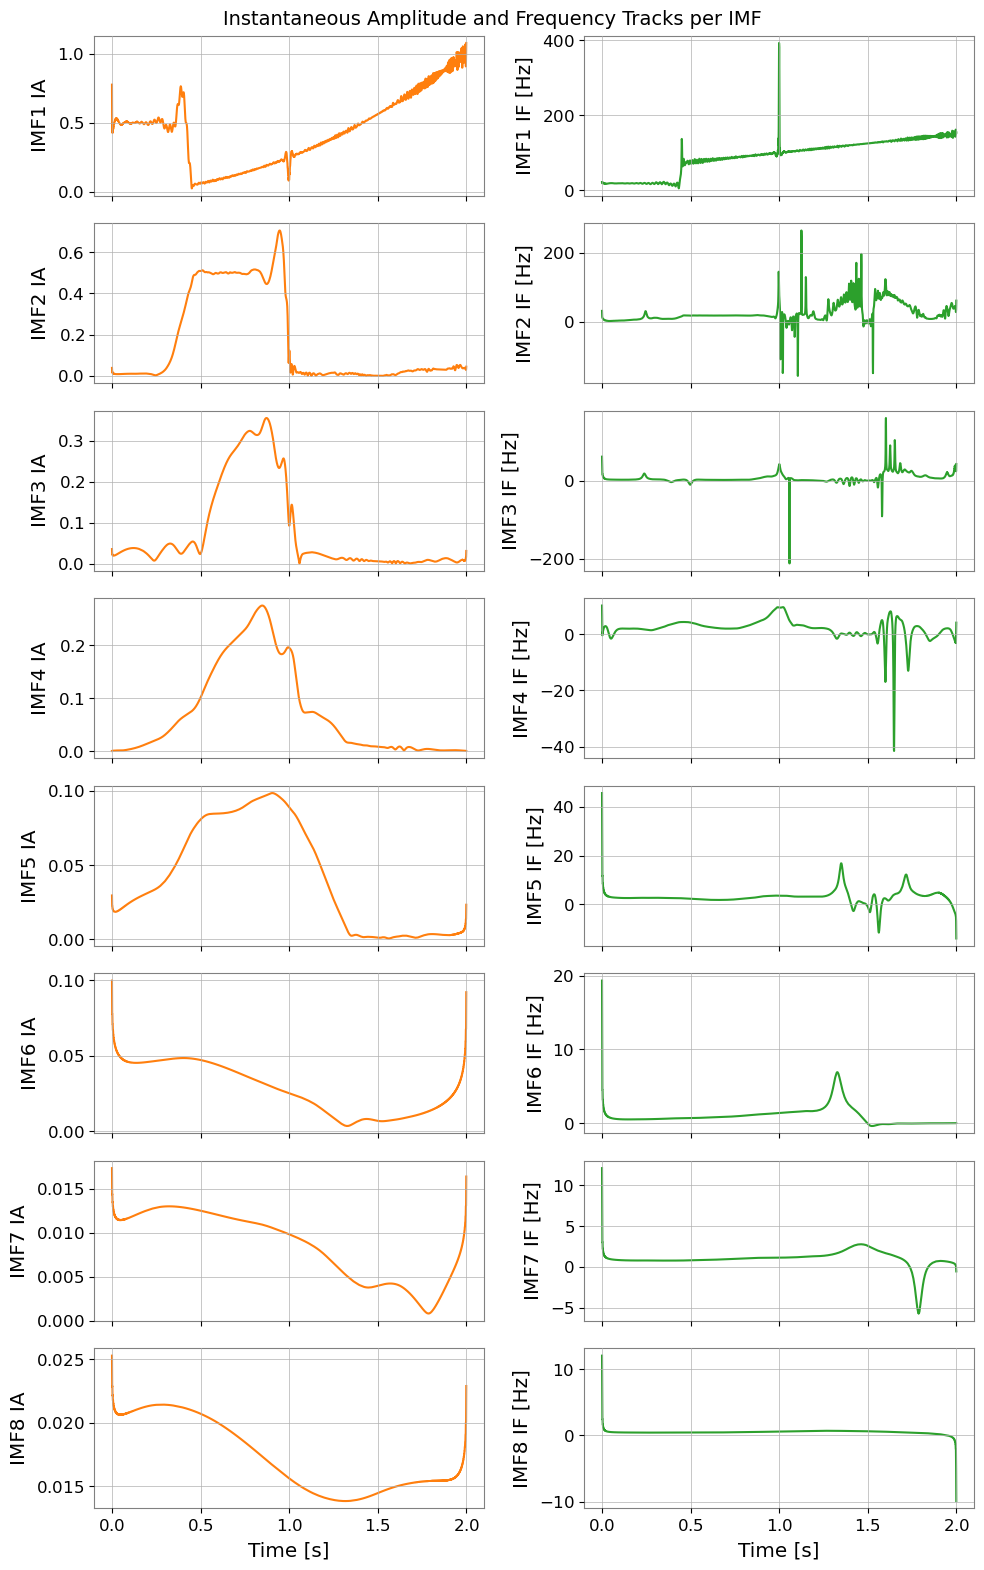

In [4]:
# IMFごとの瞬時振幅（IA）と瞬時周波数（IF）をプロット
fig2, axes2 = plt.subplots(num_imfs, 2, figsize=(10, 2 * num_imfs), sharex=True)
fig2.suptitle("Instantaneous Amplitude and Frequency Tracks per IMF", fontsize=14)

if num_imfs == 1:
    axes2 = np.array([axes2])  # shape を2次元に揃える

for i, key in enumerate(imfs.keys()):
    # 瞬時振幅 (IA)
    ia_ts = ia_dict[key]
    axes2[i, 0].plot(ia_ts, color='C1')
    axes2[i, 0].set_ylabel(f"{key} IA")
    # 瞬時周波数 (IF)
    if_ts = if_dict[key]
    axes2[i, 1].plot(if_ts, color='C2')
    axes2[i, 1].set_ylabel(f"{key} IF [Hz]")

# 一番下のサブプロット群にのみ時間軸ラベルを付加
for ax in axes2[-1, :]:
    ax.set_xlabel("Time [s]")

plt.tight_layout()
plt.show()

このプロットでは、各IMFについて左列に瞬時振幅、右列に瞬時周波数を描画しています。たとえば、IMF1 の行では左に IMF1 の振幅包絡 (IA)、右に IMF1 の瞬時周波数 (IF) が時間軸上に示されます。これにより、IMFごとのエネルギー強度や周波数成分が時間とともにどのように変動しているかを追跡することができます。

## 5. ヒルベルトスペクトラムの描画

最後に、Hilbert スペクトラム（時間‐周波数‐振幅の分布）を2次元カラーマップとして描画します。Hilbertスペクトラムでは、時間‐周波数平面上に信号の強度（振幅の2乗など）を色で表現します。`gwexpy`では、`hht(output="spectrogram")` を使って直接スペクトログラム形式の結果を取得できます。ここではそれをプロットします。

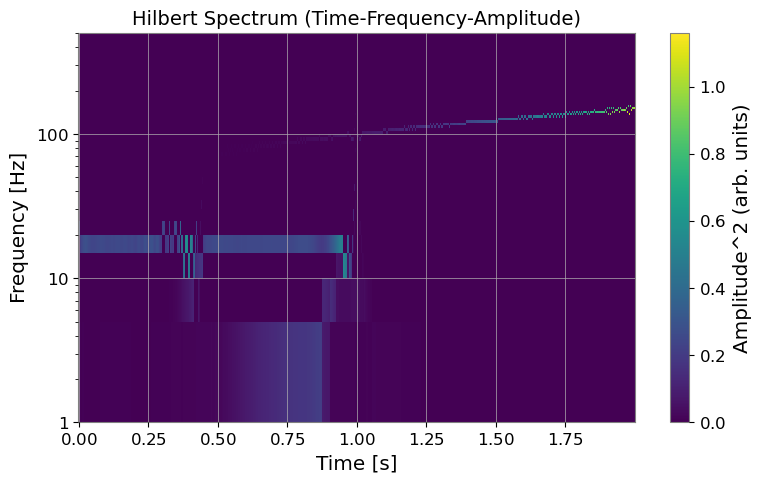

In [5]:
# Hilbert スペクトラム（時間-周波数強度分布）を計算してプロット
hilbert_spec = ts.hht(emd_method="emd", output="spectrogram")  # Spectrogram オブジェクト
fig3, ax3 = plt.subplots(figsize=(8, 5))

# pcolormeshでスペクトログラムを描画（瞬時振幅^2を強度としてカラーマップ表示）
t_vals = hilbert_spec.times.value
f_vals = hilbert_spec.frequencies.value
mesh = ax3.pcolormesh(t_vals, f_vals, hilbert_spec.value.T, shading='auto', cmap='viridis')
cb = fig3.colorbar(mesh, ax=ax3, label='Amplitude^2 (arb. units)')
ax3.set_title("Hilbert Spectrum (Time-Frequency-Amplitude)", fontsize=14)
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("Frequency [Hz]")
ax3.set_yscale("log")
ax3.set_ylim(1,500)
plt.tight_layout()
plt.show()

上記では、`output="spectrogram"` として再度 HHT を計算し、Hilbertスペクトラムを取得しています。`Spectrogram` オブジェクトに含まれる時間軸・周波数軸・強度情報を取り出し、matplotlib の `pcolormesh` を用いてプロットしています。カラーバーの値は各時間・周波数における信号強度（ここでは瞬時振幅の二乗に比例）を示しています。これにより、信号のエネルギーが時間‐周波数平面上でどの周波数帯に分布しているか（例：チャープ成分の周波数上昇や、低周波成分の消滅）を視覚的に捉えることができます。

以上のコードにより、Hilbert-Huang変換を用いた重力波形解析の基本的な流れを示すことができました。この例を発展させることで、実際の観測データへの適用や特徴抽出に応用することが可能です。